In [1]:
%matplotlib notebook

This script will plot an overview of all the trajectories to give a visual impression of how the fry aggregate around the virtual white light source compared to the control.

    
I like to use functions when plotting data as it helps to make sure there are no typos when comparing
an experimental to a control condition! 

Note, that the control condition has to be treated differently as the simulated virtual reality has to be calculated here (post-hoc)!

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import math
import pickle
import pandas as pd
from skimage import draw
from scipy.signal import find_peaks
from scipy.ndimage.interpolation import affine_transform
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# This will change to the default sans-serif font
plt.rcParams["font.family"] = "sans-serif"
# This defines that the default will be Helvetica
#plt.rcParams["font.sans-serif"] = "Arial"
import matplotlib.patches as mpatches
from pathlib import Path
import shared_functions

In [3]:
home_path = os.getcwd()
# Set to True to save plots 
save_plot = False

data_path = Path(home_path, 'data/gaussian_arena/')
data_path_ctr = Path(home_path, 'data/control/')
# all the figures will be saved in this folder
target_path = Path(home_path, 'plots/')
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [4]:
def collect_trajectories(path, control = False):
    """
    This function collects all the trajectory data and prepares it for plotting:
    
    1) It collects the raw x/y coordinates of the centroid,
    2) applies a the open triangle filter with window size 1 second (same when calculating speed),
    3) and identifies the virtual white light source peak    
    """
    # First, all the data is collected:
    folders = [x for x in path.iterdir() if x.is_dir()]

    gauss_max_coordinates = np.zeros((2,len(folders)))

    for i, folder_name in enumerate(folders):
        print('Analyzing ' + folder_name.parts[-1])

        files = [x for x in folder_name.iterdir() if x.is_file()]
        # find the data_file.csv to get the distance to source of the centroid
        for file in files:
            if 'data.csv' in file.parts[-1]:
                data = pd.read_csv(file)

        with open(Path(folder_name, 'experiment_settings.json'), 'r') as file:
            experiment_settings = json.load(file)
            fps = experiment_settings['Framerate']
            pixel_per_mm = experiment_settings['Pixel per mm']
            dish_center_x = experiment_settings['Dish Center X']
            dish_center_y = experiment_settings['Dish Center Y']
            dish_diameter = experiment_settings['Dish Diameter']

        if i ==0:
            all_pixel_per_mm_gauss = np.zeros(len(folders))
        all_pixel_per_mm_gauss[i] = pixel_per_mm

        if i == 0:
            mask_to_indicate_dish = np.zeros((480,640, len(folders)),dtype=np.bool_)

        rr, cc = draw.circle(dish_center_y, dish_center_x, dish_diameter, shape = (480,640))
        mask_to_indicate_dish[rr,cc,i] = True

        y = np.asarray(data['Y-Centroid'])
        x = np.asarray(data['X-Centroid'])

        if i == 0:
            centroid_coordinates = np.zeros((x.shape[0],2,len(folders)))
            all_centroid_coordinates_filt = np.zeros((x.shape[0],2,len(folders)))
        centroid_coordinates[:, 0, i] = y
        centroid_coordinates[:, 1, i] = x

        # open triangle kernel - starts at maximum in center, ignores first half (-1), then linear slope
        kernel_length = 30 # needs to be odd!!
        # create the series
        kernel = np.arange(kernel_length)
        # invert all values
        kernel = kernel_length-kernel
        # cut of in center
        kernel[0:int(np.ceil(kernel.shape[0]/2))] = 0
        # normalize to one
        kernel = kernel/np.sum(kernel)

        # filter x/y coordinates using the half-triangle
        centroid_filt_y =  np.floor(np.convolve(y,kernel,'same'))
        centroid_filt_x =  np.floor(np.convolve(x,kernel,'same'))
        centroid_filt = np.asarray((centroid_filt_y, centroid_filt_x)).T

        all_centroid_coordinates_filt[:,:,i]= centroid_filt

        # get the arena
        for file in files:
            if 'csv' and '640x480' in file.parts[-1]:
                virtual_arena = np.genfromtxt(str(file), delimiter=',')
                
        if control:
            data_first_frame = []
            with (open(Path(folder_name, 'first_frame_data.pkl'), 'rb')) as openfile:
                while True:
                    try:
                        data_first_frame.append(pickle.load(openfile))
                    except EOFError:
                        break
            
            
            virtual_arena = shared_functions.adjust_VR_arena_to_animal( \
                data_first_frame, 
                centroid_coordinates[:,:,i],
                home_path = home_path)

        # Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of 
        # the animal)
        max_arena_indices = np.where(virtual_arena == np.amax(virtual_arena))
        # just the the first one as there are only two anyways and it's only used to center the image
        gauss_max_coordinates[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]
        
    return(gauss_max_coordinates, all_centroid_coordinates_filt, pixel_per_mm)

In [5]:
def plot_line_centered(max_stim_coordinate,
                      centroid_coordinates,
                      pixel_per_mm,
                      ID):
    """
    This function plots the trajectories.
    
    As each experiement has the virtual white light source at a different position in the frame
    as it depends on the original animal position, the trajectories are adjusted to center the 
    virtual white light source. 
    """
    fig=plt.figure(figsize=(7,5.25))
    ax=fig.add_subplot(111)
    ax.set_rasterization_zorder(1)
    # center the maximum value and the corresponding x/y values
    for i in range(max_stim_coordinate.shape[1]):
        y_shift = (480/2-max_stim_coordinate[0,i])
        x_shift = (640/2-max_stim_coordinate[1,i])
        shifted_y = centroid_coordinates[30:-30,0,i] + y_shift
        shifted_x = centroid_coordinates[30:-30,1,i] + x_shift

        #ax.scatter(x=shifted_x,
        #           y=shifted_y,alpha=0.01, c='k')
        ax.plot(shifted_x,shifted_y, alpha=0.25, c='k',zorder=0)
        
    #draw circles with radius 5,10,15,20 to get diameter 10,20,30 and 40mm
    for i in range(4):
        radius = (i+1)*5*pixel_per_mm
        circle = plt.Circle((320, 240), radius, color='r', fill=False, ls=':')#,lw=0.5)
        ax.add_artist(circle)
        
    # add scalebar
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(ax.transData,
                           50*pixel_per_mm, '50mm', 
                           'lower right',
                           pad=0.1,
                           color='k',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

    ax.add_artist(scalebar)

    ax.set_ylim(0,480)
    ax.set_xlim(0,640)
    #ax.axis('off') # Don't use - will break the rasterization/alpha levels
    ax.tick_params(axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False, # labels along the bottom edge are off)
        labelleft=False)
    if save_plot:
        fig.savefig(Path(target_path, ID))#, rasterized=True, dpi=300)

Analyzing 01.07.2018_12-24-50_Casper AB
Analyzing 01.07.2018_14-25-37_Casper AB
Analyzing 01.07.2018_14-56-01_Casper AB
Analyzing 01.07.2018_15-15-17_Casper AB
Analyzing 01.07.2018_15-21-37_Casper AB
Analyzing 01.07.2018_15-31-53_Casper AB
Analyzing 01.07.2018_15-45-35_Casper AB
Analyzing 01.07.2018_16-28-07_Casper AB
Analyzing 01.07.2018_16-38-07_Casper AB
Analyzing 01.07.2018_16-56-10_Casper AB
Analyzing 01.07.2018_17-05-04_Casper AB
Analyzing 01.07.2018_18-16-36_Casper AB
Analyzing 01.07.2018_18-49-55_Casper AB


<IPython.core.display.Javascript object>


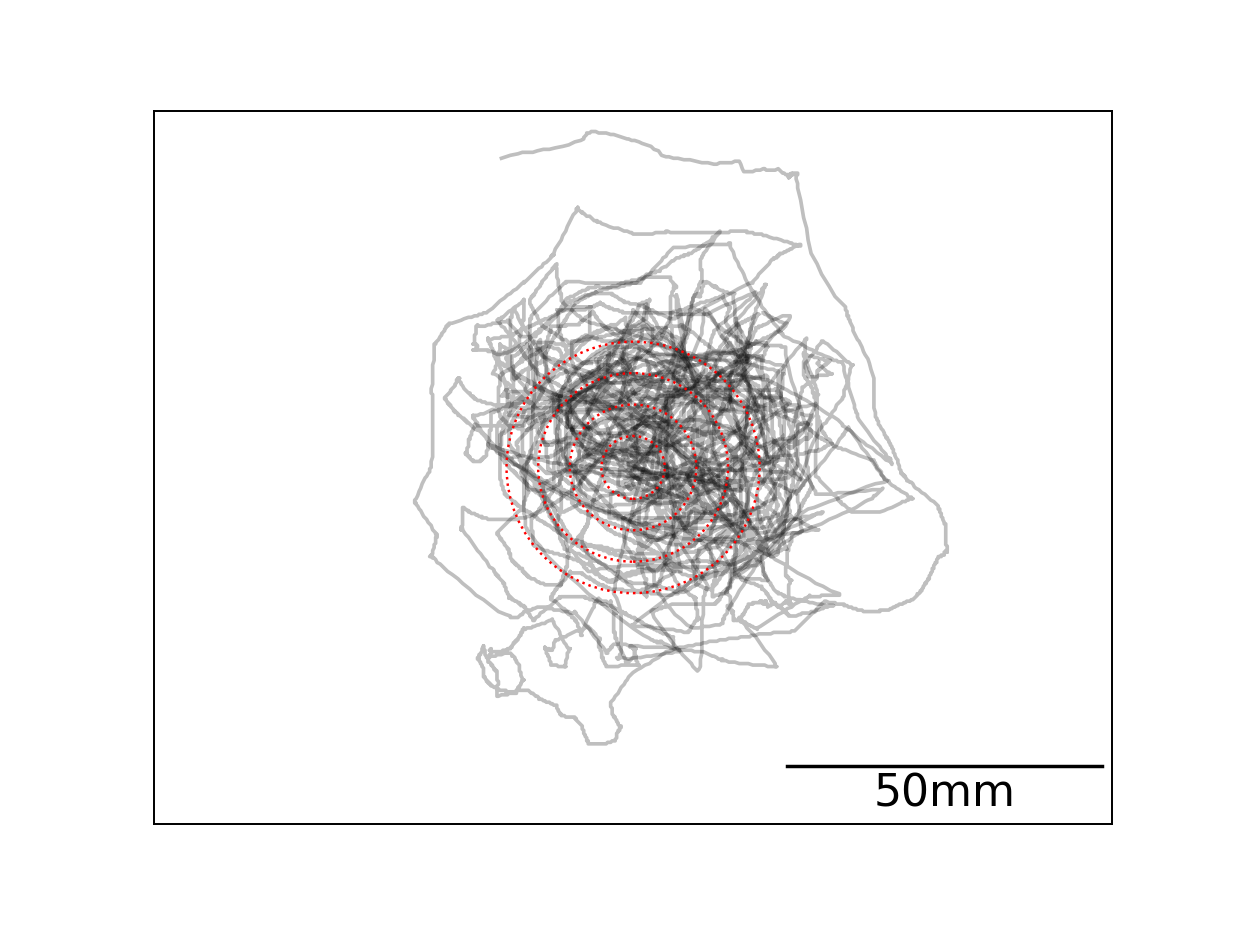

In [6]:
# Plotting the experimental data
gauss_max_coordinates, all_centroid_coordinates_filt, pixel_per_mm = collect_trajectories(path=data_path)

plot_line_centered(gauss_max_coordinates,
                  all_centroid_coordinates_filt,
                  pixel_per_mm,
                  'Fig4d_VR.eps')

Analyzing 01.07.2018_19-08-12_Casper AB
Analyzing 01.07.2018_20-23-12_Casper AB
Analyzing 01.07.2018_20-16-58_Casper AB
Analyzing 01.07.2018_20-11-27_Casper AB
Analyzing 01.07.2018_20-01-43_Casper AB
Analyzing 01.07.2018_19-53-46_Casper AB
Analyzing 01.07.2018_19-44-51_Casper AB
Analyzing 01.07.2018_19-37-48_Casper AB
Analyzing 01.07.2018_19-26-50_Casper AB
Analyzing 01.07.2018_19-22-20_Casper AB
Analyzing 01.07.2018_19-13-46_Casper AB


<IPython.core.display.Javascript object>


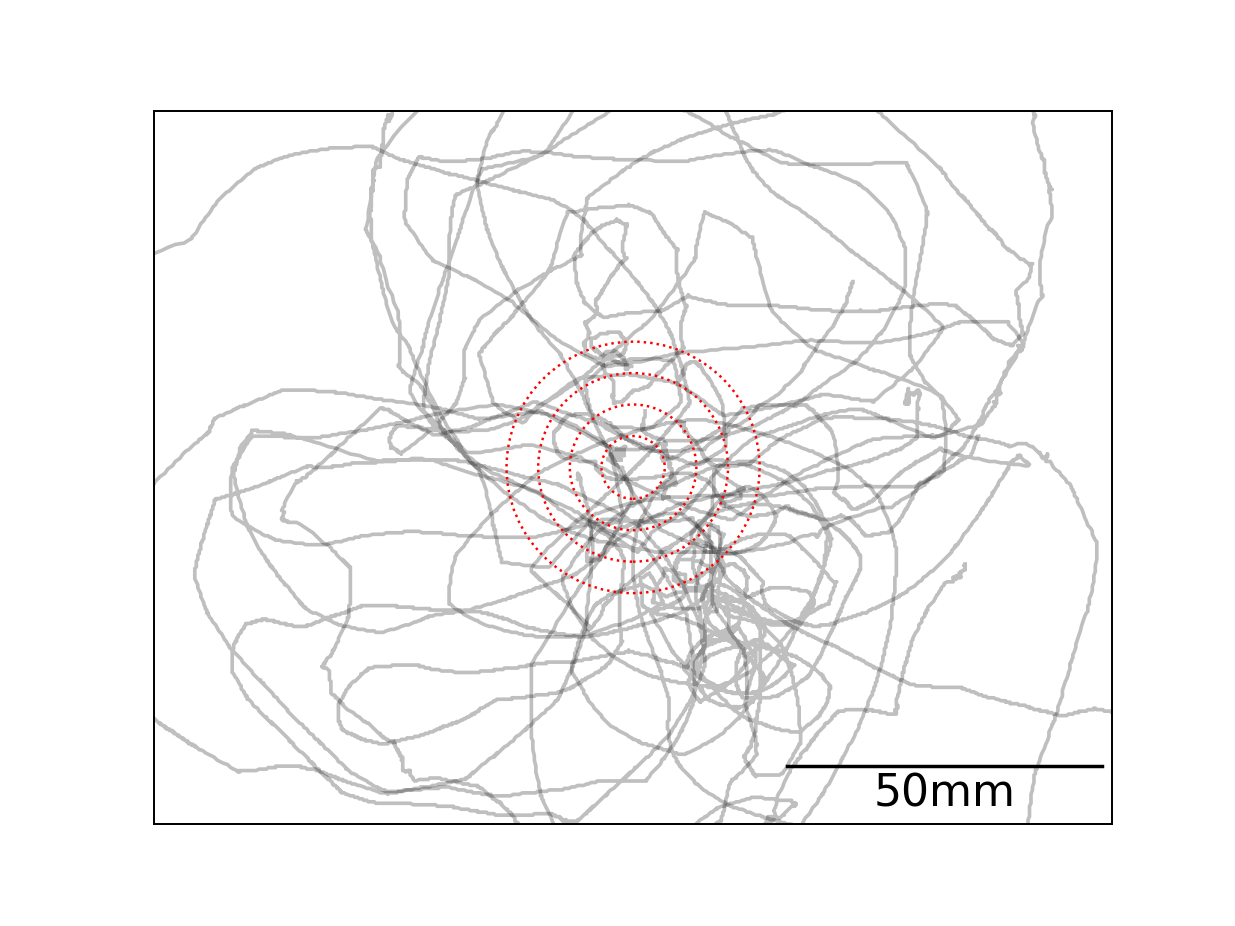

In [7]:
# Plotting the experimental data
gauss_max_coordinates_ctr, all_centroid_coordinates_filt_ctr, pixel_per_mm = \
        collect_trajectories(path=data_path_ctr,control=True)

plot_line_centered(gauss_max_coordinates_ctr,
                  all_centroid_coordinates_filt_ctr,
                  pixel_per_mm,
                  'Fig4d_ctr.eps')